# Exploration 10. News Summarization

### 텍스트 요약
상대적으로 긴 문장으로 짧은 문장으로 변환하는 기법을 텍스트 요약이라고 합니다. Ex 10에서는 뉴스 요약을 해보겠습니다. 

텍스트 요약에는 두 가지 방법, Extractive Summarization, Abstractive Summarization이 있습니다. Extractive의 경우 가장 의미있는 문장을 원문 안에서 추출해 내는 방식이고, Abstractive는 원문을 요약하는 새로운 문장을 만들어내는 방식입니다.

이 프로젝트에서는 원문과 그에 해당하는 요약문을 주고(지도학습) seq2seq와 Attention을 사용하여 원문 -> 요약문으로의 Abstractive Summarization을 실시하겠습니다. 이는 일반적인 번역과 매우 유사한 과정을 거치는 것입니다.

## load data

전처리 및 모델 학습에 필요한 라이브러리를 import하고, Amazon 리뷰 데이터셋을 활용합니다.

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

print('Done')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Done


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


모델이 text를 입력받아 context vector를 만들어내고, 출력단이 context vector를 통해 headlines와 가까운 문장을 만들어내는 것이 목표입니다. 

In [4]:
data = data[['text', 'headlines']]
data.sample(10)

,text,headlines
3867,A Thai man who felt neglected by his in-laws s...,"Thai man shoots 6 family members, kills himsel..."
49919,The Centre has proposed the adoption of the 'S...,Govt proposes 'Singapore Model' to counter rad...
95960,MPs played football in Parliament on Wednesday...,MPs play football in Parliament to promote U-1...
75807,Around 30 children being treated for encephali...,30 children die in 48 hours in UP hospital
32643,The European Union on Thursday launched 'Disco...,"European Union invites 15,000 teens to travel ..."
27746,After a video of his son thrashing a man circu...,Don't make mountain out of molehill: MLA on so...
14035,China's largest oil and gas producer PetroChin...,PetroChina plans to open first India office in...
34118,"The Delhi HC has said Airtel's advertisements,...",Airtel disclaimer in IPL ad campaign 'not in b...
75297,After a large majority of its population voted...,Sikkim was not part of India for 28 years afte...
86099,A Toronto couple has accused Uber's delivery s...,"Uber accused of sending couple mouldy, half-ea..."


In [5]:
data.rename(columns = {'text': 'Text', 'headlines': 'Summary'}, inplace = True)

## preprocess data (1)

In [6]:
# Text의 중복을 제거합니다.
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [7]:
# 결측치를 확인합니다.
print(data.isnull().sum())

Text       0
Summary    0
dtype: int64


In [8]:
# 결측치를 제거합니다.
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## preprocess data (2)

자연어 데이터의 문제를 완화하는 전처리를 시도합니다. "you're"과  "you are "은 같은 말이고, "너는"과 "넌" 역시 같은 말입니다. 또한, '.........'과 '...............' 을 서로 다른 단어으로 생각할 것인지, '.'라는 단어가 여러 개 나열 된 것은 동일하지만 그 개수에서 차이를 보인다고 생각할 것인지에 대해 명확한 규정이 존재하지 않으므로,
어떤 판단기준으로 단어를 선정할 것인지는 엔지니어에 달려 있습니다. 
모델이 학습할 때 혼란을 덜어줄 것 같은 전처리를 직관적이지만, 가장 효율적인지 알 수 없는(hueristic) 방법으로 진행하겠습니다.

[Hueristic - Wikipedia](https://en.wikipedia.org/wiki/Heuristic)

In [9]:
# 정규화 사전 - 축약어를 분해할 때 사용합니다
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
# 불용어 사전 - 문맥과 무관하게 자주 나와 context vector에 담겨있는 정보를 희석할 
#               염려가 있는 단어는 사용하지 않도록 합니다.
 
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

불용어 사전에서 의문이 드는 점은, 부정어(no, not, nor, but)등도 포함되어 있다는 점인데, 이들은 사용하도록 하겠습니다. 또한, 뉴스에서 의미를 파악하는데 중요할 것 같은 단어도 사용하도록 하겠습니다

In [11]:
selection = ['but', 'no', 'not', 'nor', 'only', 'while', 'before', 'after', 'under', \
            'again', 'further']

my_stopwords = list(
                    filter(lambda word: word not in selection,
                        stopwords.words('english')
                        )
                    )

In [12]:
print('사용자화 불용어 개수: ', len(my_stopwords))
print(my_stopwords)

사용자화 불용어 개수:  168
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'if', 'or', 'because', 'as', 'until', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "

정규표현식과 불용어 사전을 이용해 전처리를 진행합니다

In [206]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub(r"[^a-zA-Z!?.]+", " ", sentence) # 영어 외 문자(숫자, 규격 외 특수문자 등) 공백으로 변환
    
    sentence = re.sub('[m]{3,}', 'm', sentence)  # Ex) ummmmmmm yeah -> um mm yeah
    sentence = re.sub('[o]{3,}', 'o', sentence)
    
    ####
    sentence = re.sub(r'[!]{1,}', r' !! ', sentence)
    sentence = re.sub(r'[?]{1,}', r' ?? ', sentence)
    sentence = re.sub(r'[.]{1,}', r" .. ", sentence)
    
    

    sentence = re.sub(r'[" "]+', r' ', sentence)
    

    ####
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in my_stopwords if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [14]:
preprocess_sentence("Helloooooo, ....!........what's your name??????????????  not so good?")

'hello .. !! .. name ?? not good ??'

In [15]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father ..
great way to start the day !!


multiprocessing을 이용하여 전체 문장을 전처리합니다

In [16]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
    texts = []
    for s in sentences:
        texts += preprocess_sentence(s, remove_stopwords),
    return texts

def preprocess_data(data, remove_stopwords=True):
    start_time = time.time()
    num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

    text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
    pool = Pool(num_cores)

    processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
    pool.close()
    pool.join()
    print(time.time() - start_time, " seconds")
    return processed_data

clean_text = preprocess_data(data['Text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

clean_summary = preprocess_data(data['Summary'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_summary)

10.102557182312012  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience .. program upgrad degree career support helped transition data scientist tech mahindra salary hike .. upgrad online power learning powered lakh careers ..'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year .. pranav kaushik delhi techie bagged reward after spending cred coins .. users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult .. fit ..'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series .. india lost international match under rohit sharma captaincy after consecutive victories dating back march .. match witnessed india getting seventh lowest total odi cricket history ..'
 ...
 'according reports new version science fiction film matrix development .. michael jor

In [17]:
#DataFrame으로 저장합니다
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [18]:
# 결측치 확인 74개의 빈 summary 확인되었습니다
data.isnull().sum()

Text       0
Summary    0
dtype: int64

In [88]:
# 결측치 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 93154


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


자연어 관련 전처리가 완료되었습니다

## preprocess data (3)

인공지능 모델에게 이 데이터를 먹이려면, 자연어 형태가 아닌 정수로 이루어진 numpy ndarray 형태로 바꾸어 주어야 합니다. ndarray는 모든 행의 차원(길이)가 같아야 하므로, 긴 문장이든 짧은 문장이든 특정한 길이로 바꿔주어야 합니다. 이때,  긴 문장의 경우 제외를 할 수도 있고, 앞이나 뒤를 잘라 특정 길이로 바꿔 줄 수도 있습니다. 짧은 문장의 경우에도, 제외를 하거나 앞 뒤에 의미없는 표시(padding)을 넣어줍니다

단어로 분해 후에는 각 단어를 출현 빈도순으로 정리하여 {단어: 출현 빈도 순위} 인 딕셔너리와 {출현 빈도 순위: 단어}인 딕셔너리를 만듭니다. 이때 출현한 모든 단어를 저장하는 대신, '사전'의 길이를 조정합니다. 이를 통해서 분해된 문장을 정수로 인코딩할 수 있습니다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 67
텍스트의 평균 길이 : 39.22306832045547
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.340270435136235


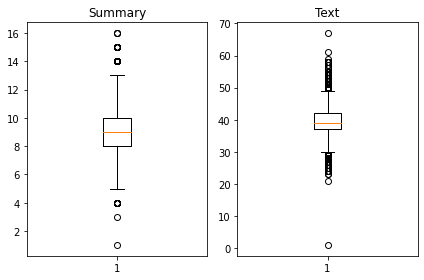

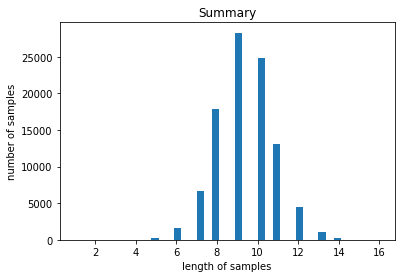

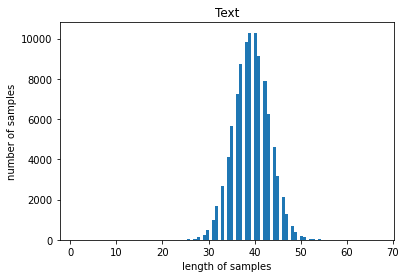

In [20]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

데이터의 분포가 넓게 퍼져있음을 알 수 있습니다. 이 프로젝트의 목표는 긍정/부정 분석이 아니고, 뉴스를 요약하는 것이며, 짧은 Text의 경우, padding을 pre로 주게 된다면, 해당 단어가 연이은 padding 뒤에 나와 그에 연관된 context vector가 희석 없이 decoder로 넘어가게 되어 오히려 너무 강한 영향력을 행사할 것 같습니다. 따라서 짧은 텍스트에서 얻을 수 있는 정보는 모두 긴 Text에서 충분히 얻을 수 있다고 가정하고 너무 짧거나 긴 Text를 갖는 데이터포인트를 제거하겠습니다

In [21]:
# 최소, 최대 사이에 있는 샘플을 골라 냅니다.
def bandpass_len(min_len, max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len) and (len(s.split()) >= min_len):
            cnt = cnt + 1
    print(f'전체 샘플 중 길이가 {min_len} 이상,{max_len} 이하인 샘플의 비율:{cnt / len(nested_list)}')

In [22]:
bandpass_len(1, 29, data['Text'])

전체 샘플 중 길이가 1 이상,29 이하인 샘플의 비율:0.004747864985766572


In [23]:
bandpass_len(30, 46, data['Text'])

전체 샘플 중 길이가 30 이상,46 이하인 샘플의 비율:0.9668971126474176


In [24]:
bandpass_len(47, 3000, data['Text'])

전체 샘플 중 길이가 47 이상,3000 이하인 샘플의 비율:0.02835502236681578


\[30, 46\]의 구간만 사용하겠습니다

In [25]:
text_max_len = 46; text_min_len = 30

In [26]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len \
            and len(x.split()) >= text_min_len)]


In [27]:
data

,Text,Summary
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...
4,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...
5,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...
...,...,...
98396,crpf jawan tuesday axed death sharp edged weap...,crpf jawan axed to death by maoists in chhatti...
98397,uff yeh first song sonakshi sinha starrer upco...,first song from sonakshi sinha noor titled uff...
98398,according reports new version science fiction ...,the matrix film to get reboot reports
98399,new music video shows rapper snoop dogg aiming...,snoop dogg aims gun at clown dressed as trump ...


Summary의 분포도 살펴보겠습니다

In [28]:
bandpass_len(7, 13, data['Summary'])

전체 샘플 중 길이가 7 이상,13 이하인 샘플의 비율:0.979496130551817


In [29]:
data['Summary'][data['Summary'].apply(lambda x: len(x.split())<=6)]

22               killed injured in saudi arabia floods
37              pakistan holds keys to war afghanistan
77               swine flu outbreak kills in rajasthan
182         confiscated benami assets worth crore dept
196               nana patekar mother passes away aged
                             ...                      
98093         taliban made crore selling pistachios in
98098              year old homeless man gets makeover
98250    union cabinet approves national health policy
98324     trailer of baahubali the conclusion released
98327               ranchi becomes india th test venue
Name: Summary, Length: 1739, dtype: object

한 단어로 이루어진 summary는 삭제하고, 10 이하의 샘플만 사용하겠습니다

In [30]:
summary_max_len = 13; summary_min_len = 7

In [31]:
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len \
            and len(x.split()) >= summary_min_len)]

In [32]:
data

,Text,Summary
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...
4,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...
5,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...
...,...,...
98396,crpf jawan tuesday axed death sharp edged weap...,crpf jawan axed to death by maoists in chhatti...
98397,uff yeh first song sonakshi sinha starrer upco...,first song from sonakshi sinha noor titled uff...
98398,according reports new version science fiction ...,the matrix film to get reboot reports
98399,new music video shows rapper snoop dogg aiming...,snoop dogg aims gun at clown dressed as trump ...


In [33]:
# 토큰화
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Text,Summary,decoder_input,decoder_target
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...
5,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [34]:
# np.array로 저장
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [35]:
# train test split
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

[88990   117 27494 ... 15996  8011 12116]
테스트 데이터의 수 : 18630


In [36]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 74524
훈련 레이블의 개수 : 74524
테스트 데이터의 개수 : 18630
테스트 레이블의 개수 : 18630


### Encoding

In [37]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [38]:
threshold = 13
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 67077
등장 빈도가 12번 이하인 희귀 단어의 수: 51598
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 15479
단어 집합에서 희귀 단어의 비율: 76.9235356381472
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.488910962574639


In [39]:
src_vocab = 15478
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 15476+2으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [40]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[418, 14, 1970, 6098, 5652, 1105, 835, 276, 7842, 1275, 1847, 23, 208, 79, 788, 252, 409, 5, 16, 752, 6635, 9321, 208, 312, 532, 646, 293, 23, 208, 607, 28, 76, 9321], [3314, 6806, 1072, 4314, 1281, 854, 383, 199, 1519, 5903, 2615, 688, 8107, 12, 86, 1524, 318, 199, 1258, 5, 16, 9911, 926, 381, 58, 774, 331, 1331, 11117, 1388], [283, 51, 18, 3027, 2810, 1, 3, 2721, 173, 11441, 13, 1, 7078, 39, 71, 2, 2810, 384, 156, 3, 7078, 24, 13, 283, 934, 13, 3, 1895, 8513, 42, 2840]]


summary에 대해서는 decoder_input으로 토큰화합니다.

In [41]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [43]:
threshold = 11
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29218
등장 빈도가 10번 이하인 희귀 단어의 수: 22209
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 7009
단어 집합에서 희귀 단어의 비율: 76.01136285851187
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.849736868377141


In [44]:
tar_vocab = 7011
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 4356, 1252, 528, 2750, 2670, 4, 43, 217, 1422], [1, 704, 4236, 2555, 966, 3, 6276, 189], [1, 153, 10, 2937, 3, 337, 34, 7, 141, 4100, 238], [1, 109, 159, 110, 352, 16, 45, 1135, 4357], [1, 71, 52, 11, 320, 4, 1402, 376, 29, 110]]
target
decoder  [[4356, 1252, 528, 2750, 2670, 4, 43, 217, 1422, 2], [704, 4236, 2555, 966, 3, 6276, 189, 2], [153, 10, 2937, 3, 337, 34, 7, 141, 4100, 238, 2], [109, 159, 110, 352, 16, 45, 1135, 4357, 2], [71, 52, 11, 320, 4, 1402, 376, 29, 110, 2]]


sostoken과 eostoken이 각각 1, 2로 인코딩된 것과 변환이 제대로 되었음을 확인했습니다

In [45]:
# 결측치 제거 - eostoken만 남은 경우를 제거한다. 아마 없을 것이다
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 74524
훈련 레이블의 개수 : 74524
테스트 데이터의 개수 : 18630
테스트 레이블의 개수 : 18630


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### Padding

encoder의 경우, padding을 뒤에 넣으면 context vector가 희석되므로 앞에 padding을 넣습니다

In [46]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

# Modeling & Training

In [47]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [48]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [49]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model2 = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 46)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 46, 128)      1981184     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 46, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [50]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [51]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model2 = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 46)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 46, 128)      1981184     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 46, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [54]:
model2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model2.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
292/292 [==============================] - 214s 695ms/step - loss: 5.3847 - val_loss: 4.7588
Epoch 2/50
292/292 [==============================] - 207s 709ms/step - loss: 4.7231 - val_loss: 4.4621
Epoch 3/50
292/292 [==============================] - 207s 709ms/step - loss: 4.3720 - val_loss: 4.1541
Epoch 4/50
292/292 [==============================] - 205s 704ms/step - loss: 4.0655 - val_loss: 3.9450
Epoch 5/50
292/292 [==============================] - 207s 710ms/step - loss: 3.8285 - val_loss: 3.7956
Epoch 6/50
292/292 [==============================] - 208s 714ms/step - loss: 3.6541 - val_loss: 3.6780
Epoch 7/50
292/292 [==============================] - 207s 709ms/step - loss: 3.5019 - val_loss: 3.5909
Epoch 8/50
292/292 [==============================] - 207s 710ms/step - loss: 3.3813 - val_loss: 3.5035
Epoch 9/50
292/292 [==============================] - 208s 712ms/step - loss: 3.2679 - val_loss: 3.4447
Epoch 10/50
292/292 [==============================] - 207s 710m

In [55]:
model2.save_weights('news_summarizer_weights_1')

In [56]:
# model2.load_weights('summarizer_weights')

In [57]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [58]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [59]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [418]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [61]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [82]:
for i in range(12160, 12190):
    print('id:', i)
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

id: 12160
원문 : tamil nadu farmers monday ran naked near pm narendra modi office demanding crore drought relief fund centre reportedly comes after promised appointment modi but not allowed meet later farmers sitting protest since almost month holding skulls hands live mice mouths 
실제 요약 : tn farmers protest naked near pmo seeking drought relief 
예측 요약 :  tamil nadu cm announces pm modi worth cr on pm


id: 12161
원문 : donald trump saturday completed first days us president after taking oath office january days trump issued dozens executive orders including immigration ban citizens six muslim majority countries trump also warned north korea major conflict nuclear missile programmes weeks time 
실제 요약 : in pics trump completes first days as us president 
예측 요약 :  trump st to visit us open to us prez


id: 12162
원문 : lawsuit claimed american audio equipment company bose spying users wireless headphones app tracks music listen bose violates users privacy rights selling audio information witho

In [72]:
def show_expectation(idx):
    print("원문 :", seq2text(encoder_input_test[idx]))
    print("실제 요약 :", seq2summary(decoder_input_test[idx]))
    print("예측 요약 :", decode_sequence(encoder_input_test[idx].reshape(1, text_max_len)))
    print("\n")

In [74]:
show_expectation(12040)

원문 : nasa astronaut ricky arnold shared selfie taken spacewalk outside international space station orbits earth km altitude arnold fellow drew worked six hours swap malfunctioning cooling box nicknamed source leak five years ago another relatively box called 
실제 요약 : astronaut shares selfie taken above earth 
예측 요약 :  astronaut shares view from space station




아직 의미를 잘 파악하지 못 하는 것 같습니다. 또한 요약된 문장을 살펴보면 주어와 목적어를 같게 한 경우가 많은데, 해결이 필요합니다. 또한, Tokenize과정에서 마침표가 생략되어, 그것도 넣어주도록 하겠습니다.

# Trial 2
summary의 길이를 강하게 한정하여 의미없는 동어반복이 일어난 것 같습니다. 또한 tokenize의 filter를 수정하여 같은 모델로 학습해보겠습니다.

## load data

In [167]:
import urllib.request
data2 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [168]:
data2 = data2[['text', 'headlines']]
data2.rename(columns = {'text': 'Text', 'headlines': 'Summary'}, inplace = True)

## preprocess data

In [169]:
clean_text = preprocess_data(data2['Text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

clean_summary = preprocess_data(data2['Summary'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_summary)

10.161367654800415  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience .. program upgrad degree career support helped transition data scientist tech mahindra salary hike .. upgrad online power learning powered lakh careers ..'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year .. pranav kaushik delhi techie bagged reward after spending cred coins .. users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult .. fit ..'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series .. india lost international match under rohit sharma captaincy after consecutive victories dating back march .. match witnessed india getting seventh lowest total odi cricket history ..'
 ...
 'according reports new version science fiction film matrix development .. michael jor

In [170]:
#DataFrame으로 저장합니다
data2['Text'] = clean_text
data2['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data2.replace('', np.nan, inplace=True)

# 결측치 확인 74개의 빈 summary 확인되었습니다
data2.isnull().sum()

# 결측치 제거
data2.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data2)))

전체 샘플수 : 98401


In [171]:
bandpass_len(1, 34, data2['Text'])

전체 샘플 중 길이가 1 이상,34 이하인 샘플의 비율:0.10599485777583562


In [172]:
bandpass_len(35, 42, data2['Text'])

전체 샘플 중 길이가 35 이상,42 이하인 샘플의 비율:0.7018627859472972


In [173]:
bandpass_len(43, 3000, data2['Text'])

전체 샘플 중 길이가 43 이상,3000 이하인 샘플의 비율:0.1921423562768671


\[35, 42\]의 구간만 사용하겠습니다

In [174]:
text_max_len = 42; text_min_len = 35

In [175]:
data2 = data2[data2['Text'].apply(lambda x: len(x.split()) <= text_max_len \
            and len(x.split()) >= text_min_len)]


In [176]:
bandpass_len(7, 13, data2['Summary'])

전체 샘플 중 길이가 7 이상,13 이하인 샘플의 비율:0.9795986331518591


In [177]:
summary_max_len = 13; summary_min_len = 7;

In [178]:
data2 = data2[data2['Summary'].apply(lambda x: len(x.split()) <= summary_max_len \
            and len(x.split()) >= summary_min_len)]

앞과 동일한 처리를 합니다.

In [179]:
# 토큰화
data2['decoder_input'] = data2['Summary'].apply(lambda x : 'sostoken '+ x)
data2['decoder_target'] = data2['Summary'].apply(lambda x : x + ' eostoken')
data2.head()

# np.array로 저장
encoder_input = np.array(data2['Text']) # 인코더의 입력
decoder_input = np.array(data2['decoder_input']) # 디코더의 입력
decoder_target = np.array(data2['decoder_target']) # 디코더의 레이블

# train test split
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

[46545 48430 32283 ... 64323 64084 34778]
테스트 데이터의 수 : 13531
훈련 데이터의 개수 : 54124
훈련 레이블의 개수 : 54124
테스트 데이터의 개수 : 13531
테스트 레이블의 개수 : 13531


### Encoding

In [180]:
src_tokenizer = Tokenizer(filters='"#$%&()*+,-/:;<=>@[\\]^_`{|}~\t\n') # 토크나이저 정의, 마침표와 느낌표, 물음표는 제거하지 않습니다.
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [181]:
threshold = 8  # 희귀 단어 비율을 70%로 맞춰봅니다
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 57864
등장 빈도가 7번 이하인 희귀 단어의 수: 40833
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 17031
단어 집합에서 희귀 단어의 비율: 70.56719203649938
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.279249729848357


In [182]:
src_vocab = 17046
src_tokenizer = Tokenizer(num_words=src_vocab, filters='"#$%&()*+,-/:;<=>@[\\]^_`{|}~\t\n') # 단어 집합의 크기를 17046으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [183]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[17, 1750, 930, 255, 226, 392, 329, 2136, 5974, 11023, 3111, 695, 324, 76, 141, 952, 139, 11023, 268, 410, 259, 1854, 652, 1236, 410, 592, 1101, 1236, 2092, 476, 5311, 255, 3806], [4, 14, 37, 264, 9688, 5062, 1066, 30, 80, 63, 48, 2893, 6691, 8767, 750, 42, 28, 242, 340, 3767, 750, 5797, 3261, 2035, 838, 28, 1471, 266, 1153, 24, 24, 9, 84, 1], [3000, 2126, 99, 6141, 17029, 274, 226, 8171, 214, 129, 32, 69, 2126, 383, 111, 103, 1772, 241, 84, 3, 69, 32, 2126, 7176, 3390, 69, 5975, 2126, 87, 103, 1772]]


summary에 대해서는 decoder_input으로 토큰화합니다.

In [184]:
tar_tokenizer = Tokenizer(filters='"#$%&()*+,-/:;<=>@[\\]^_`{|}~\t\n')
tar_tokenizer.fit_on_texts(decoder_input_train)

In [185]:
threshold = 14
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 25760
등장 빈도가 13번 이하인 희귀 단어의 수: 20920
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 4840
단어 집합에서 희귀 단어의 비율: 81.2111801242236
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 11.541676596864784


In [186]:
tar_vocab = 7693
tar_tokenizer = Tokenizer(num_words=tar_vocab, filters='"#$%&()*+,-/:;<=>@[\\]^_`{|}~\t\n') 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 512, 492, 163, 7, 18, 261, 17, 1956], [1, 26, 5091, 2405, 329, 2917, 16, 1114, 3, 5407, 1502], [1, 3607, 1070, 160, 42, 310, 2344, 52, 11, 2345], [1, 3018, 6, 71, 2610, 3019, 19, 37, 443, 2145, 1872], [1, 43, 19, 3, 45, 1957, 21, 13, 178, 1250]]
target
decoder  [[512, 492, 163, 7, 18, 261, 17, 1956, 2], [26, 5091, 2405, 329, 2917, 16, 1114, 3, 5407, 1502, 2], [3607, 1070, 160, 42, 310, 2344, 52, 11, 2345, 2], [3018, 6, 71, 2610, 3019, 19, 37, 443, 2145, 1872, 2], [43, 19, 3, 45, 1957, 21, 13, 178, 1250, 2]]


sostoken과 eostoken이 각각 1, 2로 인코딩된 것과 변환이 제대로 되었음을 확인했습니다

In [187]:
# 결측치 제거 - eostoken만 남은 경우를 제거한다. 아마 없을 것이다
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 54124
훈련 레이블의 개수 : 54124
테스트 데이터의 개수 : 13531
테스트 레이블의 개수 : 13531


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### Padding

encoder의 경우, padding을 뒤에 넣으면 context vector가 희석되므로 앞에 padding을 넣습니다

In [188]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

In [189]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [190]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [191]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model2 = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 42, 128)      2181888     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 42, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [192]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [193]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model2 = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model2.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 42, 128)      2181888     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 42, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [194]:
model2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model2.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
212/212 [==============================] - 149s 652ms/step - loss: 5.5928 - val_loss: 4.8509
Epoch 2/50
212/212 [==============================] - 141s 666ms/step - loss: 4.8701 - val_loss: 4.6188
Epoch 3/50
212/212 [==============================] - 142s 669ms/step - loss: 4.6116 - val_loss: 4.3716
Epoch 4/50
212/212 [==============================] - 142s 670ms/step - loss: 4.3403 - val_loss: 4.1899
Epoch 5/50
212/212 [==============================] - 141s 666ms/step - loss: 4.1196 - val_loss: 4.0333
Epoch 6/50
212/212 [==============================] - 141s 667ms/step - loss: 3.9404 - val_loss: 3.9421
Epoch 7/50
212/212 [==============================] - 143s 673ms/step - loss: 3.7970 - val_loss: 3.8356
Epoch 8/50
212/212 [==============================] - 142s 670ms/step - loss: 3.6571 - val_loss: 3.7621
Epoch 9/50
212/212 [==============================] - 143s 673ms/step - loss: 3.5269 - val_loss: 3.6914
Epoch 10/50
212/212 [==============================] - 142s 668m

In [195]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [196]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [197]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [198]:
for i in range(12160, 12190):
    print('id:', i)
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

id: 12160
원문 : apology email sent riders new york ride hailing startup uber said expanding quickly failed prioritise people helped get us admitting fallen short uber explained radical change following investigation startup questionable work environment 
실제 요약 : we failed to prioritise riders by so uber 
예측 요약 :  uber says he is not scared of uber employee


id: 12161
원문 : irrfan khan saba qamar starrer hindi medium earned crore three days release china april film earned opening day aamir khan dangal salman khan bajrangi bhaijaan released china directed chaudhary hindi medium released india may 
실제 요약 : hindi medium earns crore in days of its china release 
예측 요약 :  irrfan khan starrer tubelight hits the theatres


id: 12162
원문 : passenger charged interfering cabin crew after new york bound jetblue flight forced make emergency landing due drunken behaviour fbi accused robin touching man head manner attacking flight attendant further put plastic but managed break 
실제 요약 : woman flyer cha

아직 마침표 처리가 안 된 것을 알 수 있습니다. 이는 tokenizer의 filters에 놓친 부분이 있어서입니다. 

잘 된 요약:

id: 12174

원문 : least eight people reportedly killed sunday attack security headquarters yemeni government city attack involved car bombing explosive belt suicide bomber while officials suspect attack carried al qaeda militants islamic state claimed responsibility attack 

실제 요약 : killed in attack on govt security headquarters 

예측 요약 :  killed in suicide attack in egypt

id: 12175

원문 : actress anushka sharma took instagram share picture husband cricketer virat kohli honeymoon heaven literally wrote alongside picture within two hours photo received million likes instagram anushka married indian cricket team captain italy intimate wedding ceremony 

실제 요약 : anushka shares pic with husband virat from their honeymoon 

예측 요약 :  anushka shares pic with virat anushka sharma with her

id: 12177

원문 : former mumbai mayor padma shri awardee nana died age sunday mumbai awarded padma shri recognition work social sector two message board marine drive reflection personality maharashtra cm devendra fadnavis said 

실제 요약 : former mumbai mayor and padma shri nana dies at 

예측 요약 :  padma shri passes away aged


-------------------------------------------------------

      
      
동어 반복:


id: 12180

원문 : tesla model electric car reportedly caught fire california after towed garage due flat car made sound produced smoke before surrounded flames owner said fire department managed control fire later likely due heat build batteries 

실제 요약 : tesla car catches fire in us few hours later 

예측 요약 :  tesla car catches fire catches fire in car crash

id: 12184

원문 : report estimates crore adults around world risk serious disease due lack physical exercise stated high income countries uk us among least active report further said women tend men almost every region throughout world 

실제 요약 : lack of exercise puts crore at risk of disease who 

예측 요약 :  lakh note ban on note ban in note ban

id: 12171

원문 : rajya sabha wednesday passed finance bill along five amendments proposed opposition bill require approval lok sabha choose reject amendments following would still considered passed parliament bill makes aadhaar mandatory filing income tax returns 

실제 요약 : finance bill passed in rajya sabha with five 

예측 요약 :  bill to bill bill passed bill passed bill passed in parliament

# Trial 3

온점이 온전히 인식되도록 수정하고 vocab size도 수정하겠습니다.

## load data

In [253]:
data3 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [254]:
data3 = data3[['text', 'headlines']]
data3.rename(columns = {'text': 'Text', 'headlines': 'Summary'}, inplace = True)

## preprocess data

In [255]:
clean_text = preprocess_data(data3['Text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

clean_summary = preprocess_data(data3['Summary'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_summary)

10.682997465133667  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience .. program upgrad degree career support helped transition data scientist tech mahindra salary hike .. upgrad online power learning powered lakh careers ..'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year .. pranav kaushik delhi techie bagged reward after spending cred coins .. users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult .. fit ..'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series .. india lost international match under rohit sharma captaincy after consecutive victories dating back march .. match witnessed india getting seventh lowest total odi cricket history ..'
 ...
 'according reports new version science fiction film matrix development .. michael jor

In [256]:
#DataFrame으로 저장합니다
data3['Text'] = clean_text
data3['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data3.replace('', np.nan, inplace=True)

# 결측치 확인 74개의 빈 summary 확인되었습니다
data3.isnull().sum()

# 결측치 제거
data3.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data3)))

전체 샘플수 : 98401


\[37, 40\]의 구간만 사용하겠습니다

In [257]:
text_max_len = 40; text_min_len = 37

In [258]:
data3 = data3[data3['Text'].apply(lambda x: len(x.split()) <= text_max_len \
            and len(x.split()) >= text_min_len)]


In [259]:
summary_max_len = 14; summary_min_len = 4;

In [260]:
data3 = data3[data3['Summary'].apply(lambda x: len(x.split()) <= summary_max_len \
            and len(x.split()) >= summary_min_len)]

In [261]:
# 토큰화
data3['decoder_input'] = data3['Summary'].apply(lambda x : 'sostoken '+ x)
data3['decoder_target'] = data3['Summary'].apply(lambda x : x + ' eostoken')
data3.head()

# np.array로 저장
encoder_input = np.array(data3['Text']) # 인코더의 입력
decoder_input = np.array(data3['decoder_input']) # 디코더의 입력
decoder_target = np.array(data3['decoder_target']) # 디코더의 레이블

# train test split
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

[11690 17440 21548 ... 32998 12988 24963]
테스트 데이터의 수 : 7829
훈련 데이터의 개수 : 31318
훈련 레이블의 개수 : 31318
테스트 데이터의 개수 : 7829
테스트 레이블의 개수 : 7829


### Encoding

In [262]:
src_tokenizer = Tokenizer(filters='"#$%&()*+,-/:;<=>@[\\]^_`{|}~\t\n') # 토크나이저 정의, 마침표와 느낌표, 물음표는 제거하지 않습니다.
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [272]:
threshold = 11  # 희귀 단어 비율을 66%로 맞춰봅니다
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 45832
등장 빈도가 10번 이하인 희귀 단어의 수: 35395
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10437
단어 집합에서 희귀 단어의 비율: 77.22770116948857
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.753856142251195


In [273]:
src_vocab = 10437
src_tokenizer = Tokenizer(num_words=src_vocab, filters='"#$%&()*+,-/:;<=>@[\\]^_`{|}~\t\n') # 단어 집합의 크기를 17046으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [275]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[256, 86, 4167, 3302, 60, 4487, 2079, 89, 42, 1443, 175, 23, 212, 3149, 154, 3, 2748, 1515, 779, 7938, 3027, 1, 89, 683, 3302, 1475, 1986, 23, 125, 1903, 5285, 220, 3, 3027, 1709, 1], [5, 15, 475, 417, 45, 3116, 174, 493, 803, 920, 6713, 2749, 56, 1, 1928, 1226, 942, 8246, 5, 15, 42, 2704, 79, 7663, 12, 1, 34, 123, 437, 527, 1568, 447, 42, 4400, 696, 5417, 1], [299, 152, 2907, 1750, 1987, 78, 1777, 3, 1341, 666, 938, 7939, 1, 718, 1410, 1750, 262, 1, 78, 1, 78, 1552, 1008, 4168, 3071, 532, 1, 78, 1, 72, 3, 1, 666, 40, 1135, 1057, 1777, 1]]


summary에 대해서는 decoder_input으로 토큰화합니다.

In [276]:
tar_tokenizer = Tokenizer(filters='"#$%&()*+,-/:;<=>@[\\]^_`{|}~\t\n')
tar_tokenizer.fit_on_texts(decoder_input_train)

In [283]:
threshold = 3
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 20877
등장 빈도가 2번 이하인 희귀 단어의 수: 11019
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9858
단어 집합에서 희귀 단어의 비율: 52.78057192125305
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.323489435314469


In [284]:
tar_vocab = 11019
tar_tokenizer = Tokenizer(num_words=tar_vocab, filters='"#$%&()*+,-/:;<=>@[\\]^_`{|}~\t\n') 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 113, 32, 3673, 667, 132, 4, 25, 205, 92, 54], [1, 19, 7021, 607, 3050, 816, 877, 716, 3, 1461, 83], [1, 143, 78, 3674, 1121, 4571, 34, 4], [1, 1462, 779, 1807, 404, 3, 50, 7022, 14, 6167], [1, 77, 268, 2187, 1393, 1265, 3, 717, 12, 470, 217]]
target
decoder  [[113, 32, 3673, 667, 132, 4, 25, 205, 92, 54, 2], [19, 7021, 607, 3050, 816, 877, 716, 3, 1461, 83, 2], [143, 78, 3674, 1121, 4571, 34, 4, 2], [1462, 779, 1807, 404, 3, 50, 7022, 14, 6167, 2], [77, 268, 2187, 1393, 1265, 3, 717, 12, 470, 217, 2]]


sostoken과 eostoken이 각각 1, 2로 인코딩된 것과 변환이 제대로 되었음을 확인했습니다

In [285]:
# 결측치 제거 - eostoken만 남은 경우를 제거한다. 아마 없을 것이다
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 31318
훈련 레이블의 개수 : 31318
테스트 데이터의 개수 : 7829
테스트 레이블의 개수 : 7829


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### Padding

encoder의 경우, padding을 뒤에 넣으면 context vector가 희석되므로 앞에 padding을 넣습니다

In [286]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

In [287]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [288]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [289]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model2 = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model2.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 40, 128)      1335936     input_16[0][0]                   
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 40, 256), (N 394240      embedding_6[0][0]                
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, None)]       0                                            
___________________________________________________________________________________________

In [290]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [291]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model2 = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model2.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 40, 128)      1335936     input_16[0][0]                   
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 40, 256), (N 394240      embedding_6[0][0]                
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, None)]       0                                            
___________________________________________________________________________________________

In [292]:
model2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model2.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
123/123 [==============================] - 94s 680ms/step - loss: 5.8097 - val_loss: 4.8810
Epoch 2/50
123/123 [==============================] - 83s 673ms/step - loss: 4.8910 - val_loss: 4.6263
Epoch 3/50
123/123 [==============================] - 83s 677ms/step - loss: 4.6869 - val_loss: 4.5085
Epoch 4/50
123/123 [==============================] - 83s 677ms/step - loss: 4.5275 - val_loss: 4.3659
Epoch 5/50
123/123 [==============================] - 84s 679ms/step - loss: 4.3522 - val_loss: 4.2553
Epoch 6/50
123/123 [==============================] - 83s 678ms/step - loss: 4.1866 - val_loss: 4.1379
Epoch 7/50
123/123 [==============================] - 83s 678ms/step - loss: 4.0600 - val_loss: 4.0526
Epoch 8/50
123/123 [==============================] - 83s 677ms/step - loss: 3.9120 - val_loss: 3.9927
Epoch 9/50
123/123 [==============================] - 83s 679ms/step - loss: 3.7991 - val_loss: 3.9367
Epoch 10/50
123/123 [==============================] - 84s 680ms/step - l

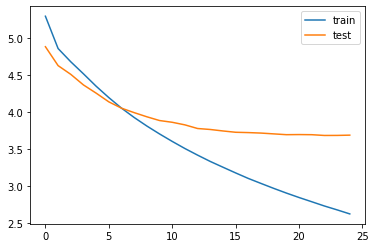

In [299]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [293]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [294]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [295]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [298]:
for i in range(6500, 6520):
    print('id:', i)
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

id: 6500
원문 : human resource development ministry reportedly planning replace western convocation indian ethnic wear .. ministry meeting officials idea viewing colonial past .. notice issued .. attire match conditions .. reflect culture hrd official said .. 
실제 요약 : govt plans to replace convocation with ethnic 
예측 요약 :  government to launch new budget


id: 6501
원문 : kerala government temporarily banned forest areas after nine people killed forest fire while hills tamil nadu .. state forest department also directed take necessary prevent forest fires .. further tour operators directed not undertake activities .. 
실제 요약 : kerala temporarily bans after tn fire kills 
예측 요약 :  illegal rainfall found in tn floods


id: 6502
원문 : according reports mark paid .. million while michelle williams got film money world .. reports added team fee while michelle not told deal .. director scott claimed actors nothing .. 
실제 요약 : mark was paid crore michelle for report 
예측 요약 :  it is the of the life 

직전의 단계에 비해 오히려 요악의 품질이 떨어진 것을 알 수 있습니다. 문장부호는 너무 자주 나와 (등장빈도 1위) 학습에 혼란을 주는 것 같습니다.

요약의 품질도 우수하고, 문법적으로도 올바른 문장을 얻었습니다. 단점으로는 원문의 가장 짧은 문장보다 요약문이 짧아질 수는 없단 것입니다. 가장 중요한 문장을 골라내는 것이므로, 생성 모델에 비해 표현력은 매우 떨어지는 단점이 있습니다.

# Trial 4
Trial2와 비슷한 방식으로 재시도합니다. 문장부호는 오히려 모델 학습에 방해가 되는 것을 확인하여 물음표만 남기고 삭제합니다. summary의 동어 반복 문제를 해결하기 위해 시도합니다.

같은 토큰이 계속 반복되는 문제는 Text Degeneration이라는 이슈로 불리며, 다음 토큰을 생성할 때 가장 높은 확률을 지닌 토큰을 추출하려는 목표를 가지고 infer하다보니 구간이 반복되는 현상이 발생합니다.

[NLG 논문 리뷰-The Curious Case of Neural Case Degeneration](https://sleekdev.tistory.com/19)

## load data

In [345]:
data4 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [346]:
data4 = data4[['text', 'headlines']]
data4.rename(columns = {'text': 'Text', 'headlines': 'Summary'}, inplace = True)

## preprocess data

In [348]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub(r"[^a-zA-Z?]+", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    
    sentence = re.sub('[m]{3,}', 'm', sentence)  # Ex) ummmmmmm yeah -> um mm yeah
    sentence = re.sub('[o]{3,}', 'o', sentence)
    
    ####
    sentence = re.sub(r'[?]{1,}', r' ?? ', sentence)
    sentence = re.sub(r'[" "]+', r' ', sentence)
    ####
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in my_stopwords if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [349]:
clean_text = preprocess_data(data4['Text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

clean_summary = preprocess_data(data4['Summary'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_summary)

10.35115122795105  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward after spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match under rohit sharma captaincy after consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film

In [350]:
#DataFrame으로 저장합니다
data4['Text'] = clean_text
data4['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data4.replace('', np.nan, inplace=True)

# 결측치 확인 0개의 빈 summary 확인되었습니다
data4.isnull().sum()

# 결측치 제거
data4.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data4)))

전체 샘플수 : 98401


In [359]:
bandpass_len(1, 24, data4['Text'])

전체 샘플 중 길이가 1 이상,24 이하인 샘플의 비율:0.0006707248910072052


In [360]:
bandpass_len(24, 43, data4['Text'])

전체 샘플 중 길이가 24 이상,43 이하인 샘플의 비율:0.9769108037519943


In [358]:
bandpass_len(44, 3000, data4['Text'])

전체 샘플 중 길이가 44 이상,3000 이하인 샘플의 비율:0.02281480879259357


\[24, 42\]의 구간만 사용하겠습니다

In [361]:
text_max_len = 42; text_min_len = 24

In [362]:
data4 = data4[data4['Text'].apply(lambda x: len(x.split()) <= text_max_len \
            and len(x.split()) >= text_min_len)]


In [371]:
bandpass_len(1, 4, data4['Summary'])

전체 샘플 중 길이가 1 이상,4 이하인 샘플의 비율:0.0001592136966236082


In [372]:
summary_max_len = 13; summary_min_len = 5;

In [373]:
data4 = data4[data4['Summary'].apply(lambda x: len(x.split()) <= summary_max_len \
            and len(x.split()) >= summary_min_len)]

앞과 동일한 처리를 합니다.

In [374]:
# 토큰화
data4['decoder_input'] = data4['Summary'].apply(lambda x : 'sostoken '+ x)
data4['decoder_target'] = data4['Summary'].apply(lambda x : x + ' eostoken')
data4.head()

# np.array로 저장
encoder_input = np.array(data4['Text']) # 인코더의 입력
decoder_input = np.array(data4['decoder_input']) # 디코더의 입력
decoder_target = np.array(data4['decoder_target']) # 디코더의 레이블

# train test split
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

[20966 27199 68761 ... 37332 32324 13143]
테스트 데이터의 수 : 18801
훈련 데이터의 개수 : 75204
훈련 레이블의 개수 : 75204
테스트 데이터의 개수 : 18801
테스트 레이블의 개수 : 18801


### Encoding

In [375]:
src_tokenizer = Tokenizer(filters='".!#$%&()*+,-/:;<=>@[\\]^_`{|}~\t\n') # 토크나이저 정의, 물음표는 제거하지 않습니다.
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [378]:
threshold = 13  # 희귀 단어 비율을 77%로 맞춰봅니다
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 67424
등장 빈도가 12번 이하인 희귀 단어의 수: 51910
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 15514
단어 집합에서 희귀 단어의 비율: 76.99038917892739
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.493425785108359


In [379]:
src_vocab = 15514
src_tokenizer = Tokenizer(num_words=src_vocab, filters='".!#$%&()*+,-/:;<=>@[\\]^_`{|}~\t\n') # 단어 집합의 크기를 15514으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [380]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1052, 367, 5699, 1100, 78, 29, 489, 3654, 1911, 3121, 1348, 76, 3671, 614, 1242, 60, 9, 6730, 349, 12, 10132, 684, 3520, 129, 20, 3654, 4741, 35, 3654, 1052, 367, 5699, 1100, 78], [1396, 5947, 394, 2067, 570, 191, 21, 21, 69, 2, 34, 2337, 3569, 4, 123, 3, 707, 501, 383, 10133, 1493, 288, 26, 806, 1150, 21, 1130, 777, 20, 30, 5138, 641, 3569, 113, 2248, 4341, 4, 318, 1493, 2998, 4742, 1993], [372, 727, 1007, 495, 2640, 6340, 1348, 630, 2725, 816, 352, 7, 1994, 682, 1, 95, 6, 7, 25, 288, 2861, 888, 457, 495, 372, 390, 228, 39, 3672, 7, 5010, 622, 1604, 888, 515, 736, 6482, 6204, 331]]


summary에 대해서는 decoder_input으로 토큰화합니다.

In [382]:
tar_tokenizer = Tokenizer(filters='".!#$%&()*+,-/:;<=>@[\\]^_`{|}~\t\n')
tar_tokenizer.fit_on_texts(decoder_input_train)

In [387]:
threshold = 12
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29303
등장 빈도가 11번 이하인 희귀 단어의 수: 22677
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 6626
단어 집합에서 희귀 단어의 비율: 77.38798075282395
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.419365793881074


In [388]:
tar_vocab = 6626
tar_tokenizer = Tokenizer(num_words=tar_vocab, filters='".!#$%&()*+,-/:;<=>@[\\]^_`{|}~\t\n') 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 3295, 1050, 5985, 1260, 32, 4, 2214, 4140], [1, 1301, 1302, 383, 51, 7, 394, 6, 1959, 1340, 1491], [1, 13, 235, 1196, 6, 364, 680, 1019, 4, 5248], [1, 39, 26, 81, 5, 845, 5046, 6, 1864], [1, 45, 2180, 1865, 68, 10, 2532, 1110, 54, 1051, 149]]
target
decoder  [[3295, 1050, 5985, 1260, 32, 4, 2214, 4140, 2], [1301, 1302, 383, 51, 7, 394, 6, 1959, 1340, 1491, 2], [13, 235, 1196, 6, 364, 680, 1019, 4, 5248, 2], [39, 26, 81, 5, 845, 5046, 6, 1864, 2], [45, 2180, 1865, 68, 10, 2532, 1110, 54, 1051, 149, 2]]


sostoken과 eostoken이 각각 1, 2로 인코딩된 것과 변환이 제대로 되었음을 확인했습니다

In [389]:
# 결측치 제거 - eostoken만 남은 경우를 제거한다. 아마 없을 것이다
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 75204
훈련 레이블의 개수 : 75204
테스트 데이터의 개수 : 18801
테스트 레이블의 개수 : 18801


### Padding

encoder의 경우, padding을 뒤에 넣으면 context vector가 희석되므로 앞에 padding을 넣습니다

In [390]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

In [391]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128 + 32
hidden_size = 256 + 64

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [392]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [393]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model2 = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model2.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 42, 160)      2482240     input_21[0][0]                   
__________________________________________________________________________________________________
lstm_16 (LSTM)                  [(None, 42, 320), (N 615680      embedding_8[0][0]                
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, None)]       0                                            
___________________________________________________________________________________________

In [394]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [395]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model2 = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model2.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 42, 160)      2482240     input_21[0][0]                   
__________________________________________________________________________________________________
lstm_16 (LSTM)                  [(None, 42, 320), (N 615680      embedding_8[0][0]                
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, None)]       0                                            
___________________________________________________________________________________________

In [396]:
model2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model2.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
294/294 [==============================] - 220s 714ms/step - loss: 5.2687 - val_loss: 4.6622
Epoch 2/50
294/294 [==============================] - 211s 719ms/step - loss: 4.6107 - val_loss: 4.2945
Epoch 3/50
294/294 [==============================] - 211s 719ms/step - loss: 4.1859 - val_loss: 3.9458
Epoch 4/50
294/294 [==============================] - 211s 720ms/step - loss: 3.8581 - val_loss: 3.7464
Epoch 5/50
294/294 [==============================] - 212s 720ms/step - loss: 3.6251 - val_loss: 3.5918
Epoch 6/50
294/294 [==============================] - 212s 721ms/step - loss: 3.4263 - val_loss: 3.4773
Epoch 7/50
294/294 [==============================] - 211s 719ms/step - loss: 3.2717 - val_loss: 3.3837
Epoch 8/50
294/294 [==============================] - 213s 725ms/step - loss: 3.1458 - val_loss: 3.3178
Epoch 9/50
294/294 [==============================] - 213s 723ms/step - loss: 3.0153 - val_loss: 3.2657
Epoch 10/50
294/294 [==============================] - 212s 722m

In [402]:
model2.save_weights('news_summarizer_weights_4')

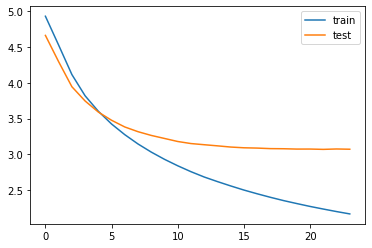

In [401]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [397]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [398]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [399]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [419]:
for i in range(1680, 1710):
    print('id:', i)
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

id: 1680
원문 : sc today warned amrapali group delaying projects saying try play smart sell every property homeless group asked valuation report properties directors managing directors days court also sought details companies responsible maintenance amrapali projects 
실제 요약 : do not play smart will you homeless sc to amrapali group 
예측 요약 :  amrapali denies being sold for selling


id: 1681
원문 : indian compound archery team deb chanu india silver medal world archery championships mexico city saturday silver fifth india world event first country compound team archery section world championships 
실제 요약 : indian team claims th world ship silver 
예측 요약 :  indian navy to be world record for the world ships


id: 1682
원문 : mumbai sessions court acquitted year old man rape charges after complainant admitted filed case fit anger woman said upset man boyfriend not talked week informed court sorted differences got married 
실제 요약 : man acquitted after woman admits filing rape case in anger 
예측 요약 :

### 결과 분석: 어느 정도 의미가 있는 문장도 나오지만, 주어와 목적어가 동일한 문장이 매우 많고, 같은 구절이 계속 반복되는 것을 알 수 있습니다. 
이러한 현상이 발생하는 이유는 추론은 전 단계의 토큰을 입력으로 받았을 때, 다음 토큰으로 올 가능성이 가장 높은 것을 선택하기 때문으로, 한번 순환에 빠지면 의미없이 같은 단어를 나열하고, 평균 길이를 넘어설 때에야 멈추게 됩니다.

현재의 목표는 기사를 요약하는 것이므로, 한 단어가 여러번 나온 문장이 그럴듯 한 문장이기 힘듭니다. 단 한번이라도 나온 토큰에 대해서는 페널티를 주도록 합니다

In [420]:
def decode_sequence_penalty(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    #### 이미 나온 단어를 기록하는 set을 만듭니다.
    token_bag = set()
    ####
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        #### 만일 예측된 단어가 이미 나온 단어라면, 그 예측치를 15%로 삭감해 다른 토큰이 선택될 수 있도록 합니다
        if sampled_token_index in token_bag:
            output_tokens[0, -1, sampled_token_index] *= 0.15
            sampled_token_index = np.argmax(output_tokens[0, -1, :])
        ####
        
        sampled_token = tar_index_to_word[sampled_token_index]
        
        #### 현재까지 나온 단어를 기록합니다.
        token_bag.add(sampled_token_index)
        ####

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [441]:
for i in range(1680, 1710):
    print('id:', i)
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence_penalty(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

id: 1680
원문 : sc today warned amrapali group delaying projects saying try play smart sell every property homeless group asked valuation report properties directors managing directors days court also sought details companies responsible maintenance amrapali projects 
실제 요약 : do not play smart will you homeless sc to amrapali group 
예측 요약 :  amrapali denies being sold for selling


id: 1681
원문 : indian compound archery team deb chanu india silver medal world archery championships mexico city saturday silver fifth india world event first country compound team archery section world championships 
실제 요약 : indian team claims th world ship silver 
예측 요약 :  indian navy to be world record for the first time


id: 1682
원문 : mumbai sessions court acquitted year old man rape charges after complainant admitted filed case fit anger woman said upset man boyfriend not talked week informed court sorted differences got married 
실제 요약 : man acquitted after woman admits filing rape case in anger 
예측 요약 : 

동어반복을 해결했습니다. 1684번 문장을 확인해보면, 확연한 차이를 알 수 있습니다. 

In [423]:
i = 1684

print('id:', i)
print("예측 요약(현행) :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
print("예측 요약(개선) :", decode_sequence_penalty(encoder_input_test[i].reshape(1, text_max_len)))


id: 1684
예측 요약(현행) :  india sl sl sl sl sl players get sl for sl
예측 요약(개선) :  india sl captain asks sri lanka to help sl


많은 고유명사는 남아있고 (유명 정치인 등) 그와 관련된 단어는 사라지는 경우도 있었습니다. ex) 유명인의 비서가 스스로 목숨을 끊었다 ~~~ (원문) -> 유명인이 극단적인 선택을 했다 (요약)

뉴스를 보고 비슷한 사건에 대해 그럴듯한 요약은 할 수 있으나, 새로운 사건에 대해서는 결과가 완벽히 들어맞지는 않는 것을 확인했습니다. 유사한 요약은 다음과 같습니다.

In [427]:
def show_better_expectation(idx):
    print("원문 :", seq2text(encoder_input_test[idx]))
    print("실제 요약 :", seq2summary(decoder_input_test[idx]))
    print("예측 요약(현행) :", decode_sequence(encoder_input_test[idx].reshape(1, text_max_len)))
    print("예측 요약(개선) :", decode_sequence_penalty(encoder_input_test[idx].reshape(1, text_max_len)))
    print("\n")

In [428]:
show_better_expectation(1709)

원문 : per reports sonam kapoor marrying businessman anand ahuja mumbai april earlier reports getting married switzerland may sonam family reportedly could not host wedding choice resort pre booked saudi princess dates 
실제 요약 : sonam to marry anand in mumbai on april reports 
예측 요약(현행) :  sonam to marry rumoured anand anand in mumbai reports
예측 요약(개선) :  sonam to marry rumoured anand in mumbai reports




In [431]:
show_better_expectation(5283)

원문 : facebook shares rose thursday after company ceo mark zuckerberg said recent data scandal not meaningful impact company facebook share sunk wiping billion market value since data scandal reported data million facebook users exploited influence us elections 
실제 요약 : fb shares rise as zuckerberg dismissed affect of data row 
예측 요약(현행) :  fb shares surge on facebook amid data scandal
예측 요약(개선) :  fb shares surge on facebook amid data scandal




In [438]:
show_better_expectation(5847)

원문 : facebook co founder ceo mark zuckerberg not sell single share fourth quarter company stock fell first quarter two years zuckerberg according bloomberg since september year old sold million shares worth around billion fund 
실제 요약 : zuckerberg did not sell single share in when facebook fell 
예측 요약(현행) :  zuckerberg loses bn in day stock market
예측 요약(개선) :  zuckerberg loses bn in day stock market




In [440]:
show_better_expectation(5889)

원문 : commerce giant amazon held early talks may submit offer buy indian rival flipkart according reports comes amid reports suggesting walmart advanced talks buy stake flipkart walmart flipkart deal value flipkart billion tiger global investors expected sell shares 
실제 요약 : amazon may offer to buy flipkart reports 
예측 요약(현행) :  amazon may buy flipkart stake in flipkart reports
예측 요약(개선) :  amazon may buy flipkart stake in reports




# 추출적 요약 해보기

In [307]:
data4 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [308]:
data4 = data4[['text', 'headlines']]
data4.rename(columns = {'text': 'Text', 'headlines': 'Summary'}, inplace = True)

In [328]:
import requests
from summa.summarizer import summarize

In [329]:
print('Summary:')
print(summarize(data4['Text'].apply(str).iloc[1], ratio=0.4))

Summary:
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


In [335]:
data4['Text'].apply(str).iloc[1]

"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more."

In [343]:
def summarize_news(idx):
    for i in idx:
        print('원문\n',data4['Text'].apply(str).iloc[i], '\n')
        print('요약\n',summarize(data4['Text'].apply(str).iloc[i], ratio=0.4),'\n\n')
        print('======================================================================================')

In [344]:
summarize_news([30, 400, 5060, 21454, 56645])

원문
 Italian third division football side Lucchese's head coach Giancarlo Favarin has been banned for five months for headbutting Alessandria's assistant coach Gaetano Mancino during a brawl following the teams' 2-2 draw on Sunday. Mancino was caught off-balance and knocked to the ground after the headbutt. Earlier in the match, Favarin had told his own player to break an opponent's legs. 

요약
 Italian third division football side Lucchese's head coach Giancarlo Favarin has been banned for five months for headbutting Alessandria's assistant coach Gaetano Mancino during a brawl following the teams' 2-2 draw on Sunday. 


원문
 The death toll from the mine dam collapse in Brazil last week has risen to 58 and more than 300 others are still missing, authorities said. The dam break caused a sea of muddy sludge to bury the cafeteria at the iron-ore mine where workers were eating lunch, before engulfing nearby houses, vehicles and roads. 

요약
  


원문
 Road Transport Minister Nitin Gadkari on Sat

# 회고 

1️⃣ 잘한 점:

불용어에서 의미를 추출해 낼 수 있는 단어는 제외하고, 여러 전처리 방법을 통해 추출적 요약에서 의미있는 결과를 얻었다.
inference mode를 수정하여 동어반복을 해결헀다

2️⃣ 어려웠던 점:

학습이 오래 걸려서 다양한 모델을 시도해 볼 수 없었다.


3️⃣ 느낀 점:

LSTM의 inference부분에 대해 글을 써 봐야 이해가 될 것 같다.
이 방식으로 제대로 된 요약을 하려면, 임베딩이 잘 되어있는 것이 매우 중요하고,  특히 뉴스의 경우, 빈도수가 작은 단어도 포함시켜야 할 것 같다.